In [85]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
#from scipy.sparse.linalg import eigsh, expm_multiply, expm

In [86]:
import importlib

import sys
sys.path.append('/Users/giovanniconcheri/Desktop/ResearchJob/Student-Research-Job/Chebyshev')
sys.path.append('/Users/giovanniconcheri/Desktop/ResearchJob/Student-Research-Job/TCI')
sys.path.append("/home/t30/all/go56vod/Desktop/Student-Research-Job/Chebyshev")
sys.path.append("/home/t30/all/go56vod/Desktop/Student-Research-Job/TCI")


import ED_Cs_Lsites as ED
import TCI_Lsite_accumulative_v1 as TCI

importlib.reload(ED)
importlib.reload(TCI)


<module 'TCI_Lsite_accumulative_v1' from '/Users/giovanniconcheri/Desktop/ResearchJob/Student-Research-Job/TCI/TCI_Lsite_accumulative_v1.py'>

In [87]:
# define Hamiltonian terms
L = 11
n = 11
dt = 1e-2
models = ['J = 1, g = 2 , Ising Model Ham. = H','J =1 g = 2 Ham. = H - k*Hzz', 'J = 1 g = 0.5, Ham. = H - h * Hxx', 'J = 1 g = 0.5, Ham. = H - k*Hzz - h*Hxx']
threshold = 30
N = 2**n
D = L
g_par = 0.1


In [88]:
# Generate Hamiltonian
Hlist = [ED.gen_Ham(L = L, model = 0), ED.gen_Ham(L = L, model = 2)]

In [89]:
Cs_theo = ED.correlator(H= Hlist[0], L = L, dt = dt,  n = n)
print(Cs_theo.shape)

for i in range(Cs_theo.shape[0]):
    for k in range(Cs_theo.shape[1]):
        if Cs_theo.real[i,k] > 1:
            print('i,k: (', i, ',', k, '), ', Cs_theo[i,k])
            Cs_theo[i,k] = 1. + 1j* Cs_theo.imag[i,k]
        if Cs_theo.imag[i,k] > 1:
            print('i,k: (', i, ',', k, '), ', Cs_theo[i,k])
            Cs_theo[i,k] = Cs_theo.real[i,k] + 1j

Expectation value $\bra{\psi_0} X_{L/2} \ket{psi_0}$=  3.14413158450403e-15
(11, 2048)
i,k: ( 5 , 0 ),  (1.000000000000002+0j)


In [90]:
N_shots = 2**13 #8192 rough estimation by Bernhard
# clip to avoid tiny negative values from rounding
std_real = np.sqrt(np.clip(1 - Cs_theo.real**2, 0, None)) / np.sqrt(N_shots)
std_imag = np.sqrt(np.clip(1 - Cs_theo.imag**2, 0, None)) / np.sqrt(N_shots)

np.random.seed(0)  # optional
Cs_noise_real = np.random.normal(loc=0.0, scale=std_real)
Cs_noise_imag = np.random.normal(loc=0.0, scale=std_imag)

Cs_noise = Cs_theo + Cs_noise_real + 1j * Cs_noise_imag
print("shapes:", Cs_theo.shape, Cs_noise.shape)

shapes: (11, 2048) (11, 2048)


In [91]:
diff_noisevstheo = Cs_theo-Cs_noise #should be difference between 2 matrices
err_max_noisevstheo = np.max(np.abs(diff_noisevstheo))/np.max(np.abs(Cs_theo))
print("Max error (noise vs theo): ", err_max_noisevstheo)
err_2_noisevstheo = np.linalg.norm(diff_noisevstheo)/np.linalg.norm(Cs_theo)
print("2-norm error (noise vs theo): ", err_2_noisevstheo)

Max error (noise vs theo):  0.05144266433826916
2-norm error (noise vs theo):  0.0467554192029927


In [92]:
# D = L #already defined above

func_vals_theo = Cs_theo.T #Cs is in the form (X,T)
func_vals_noise = Cs_noise.T

#first we define the function f(t)
# which returns the slice of func_vals along x for a specific time 
f_t_theo = lambda *t: Cs_theo.reshape((D,) + (2,) * n)[:,*t]
f_t_noise = lambda *t: Cs_noise.reshape((D,) + (2,) * n)[:,*t]

Comparison between TCI of theoretical and noisy correlation function!

In [93]:
#here we have to define func as the initialization of the class
func_theo = TCI.function(f_t_theo)

As, _, eval, err_2, err_max, func_interp_theo = TCI.accumulative_tensor_cross_interpolation(func_theo,         # function to be interpolated
                                   func_vals_theo,    
                                   D,
                                   L=n,          # number of MPS tensors
                                   iters=5)       # number of back-and-forth sweeps


print()

func_noise = TCI.function(f_t_noise)

As, _, eval, err_2, err_max, func_interp_noise = TCI.accumulative_tensor_cross_interpolation(func_noise,         # function to be interpolated
                                   func_vals_noise,    
                                   D,
                                   L=n,          # number of MPS tensors
                                   iters=5)      # number of back-and-forth sweeps   


err_max:  0.0012661466326492044
err_2:  0.0007516265897043831

repeated evaluations:  4108
unique evaluations 408
unique + repeated:  4516
total evaluations:  4516


err_max:  0.07785476003012931
err_2:  0.0797624297289923

repeated evaluations:  4108
unique evaluations 408
unique + repeated:  4516
total evaluations:  4516



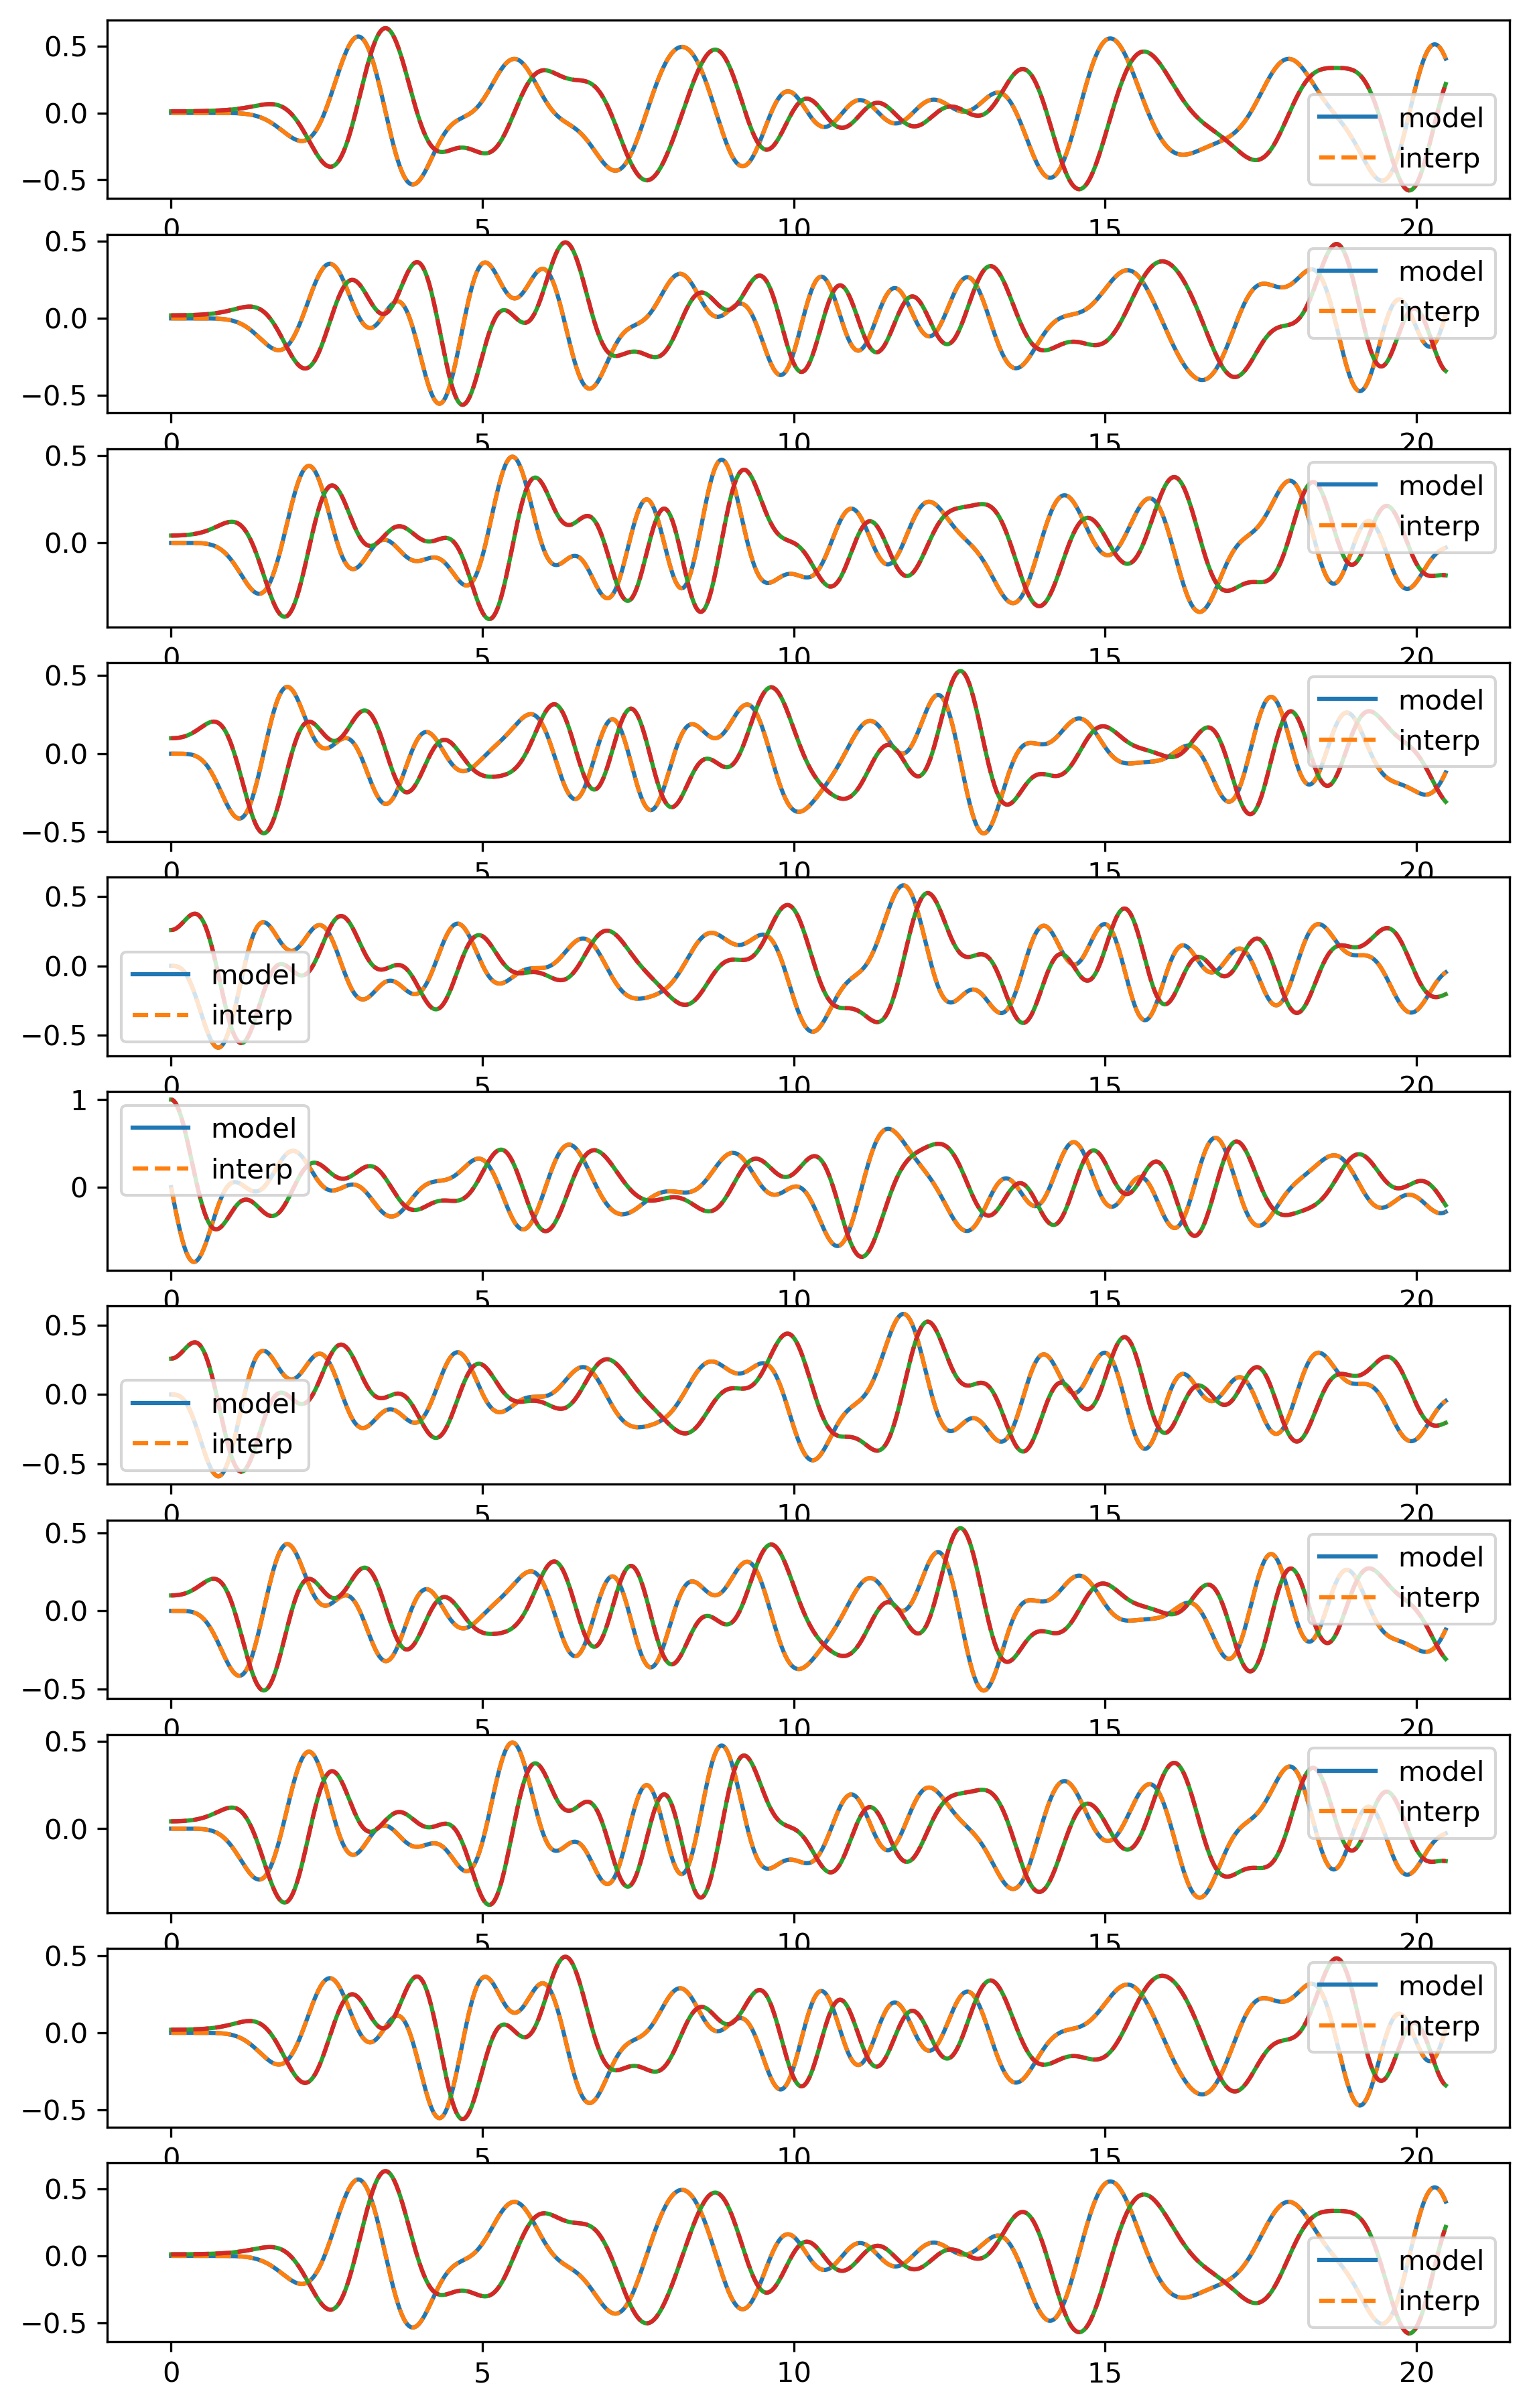

In [94]:
ts = np.arange(N)*dt
D_list = np.arange(D)

fig, axs = plt.subplots(nrows=D, figsize=(9,15), dpi=300)


for i,item in enumerate(D_list):
    axs[i].plot(ts, np.imag(func_vals_theo[:,item]), '-', label = 'model')
    axs[i].plot(ts, np.imag(func_interp_theo[:,item]), '--', label = 'interp')
    axs[i].plot(ts, np.real(func_vals_theo[:,item]), '-')
    axs[i].plot(ts, np.real(func_interp_theo[:,item]), '--')   
    axs[i].legend()

plt.show()  

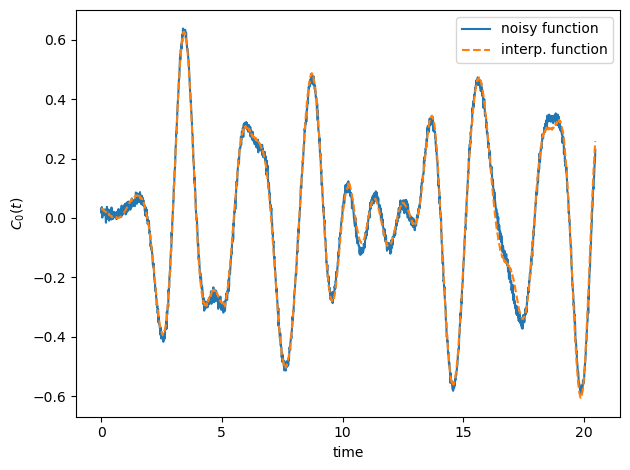

In [95]:
plt.plot(ts, np.real(func_vals_noise[:,0]), '-', label = 'noisy function')
plt.plot(ts, np.real(func_interp_noise[:,0]), '--', label = 'interp. function')
plt.xlabel('time')
plt.ylabel(r'$C_0(t)$')
plt.legend()
plt.tight_layout()
plt.savefig("figures_Lsite_noise/noisy_example.pdf")

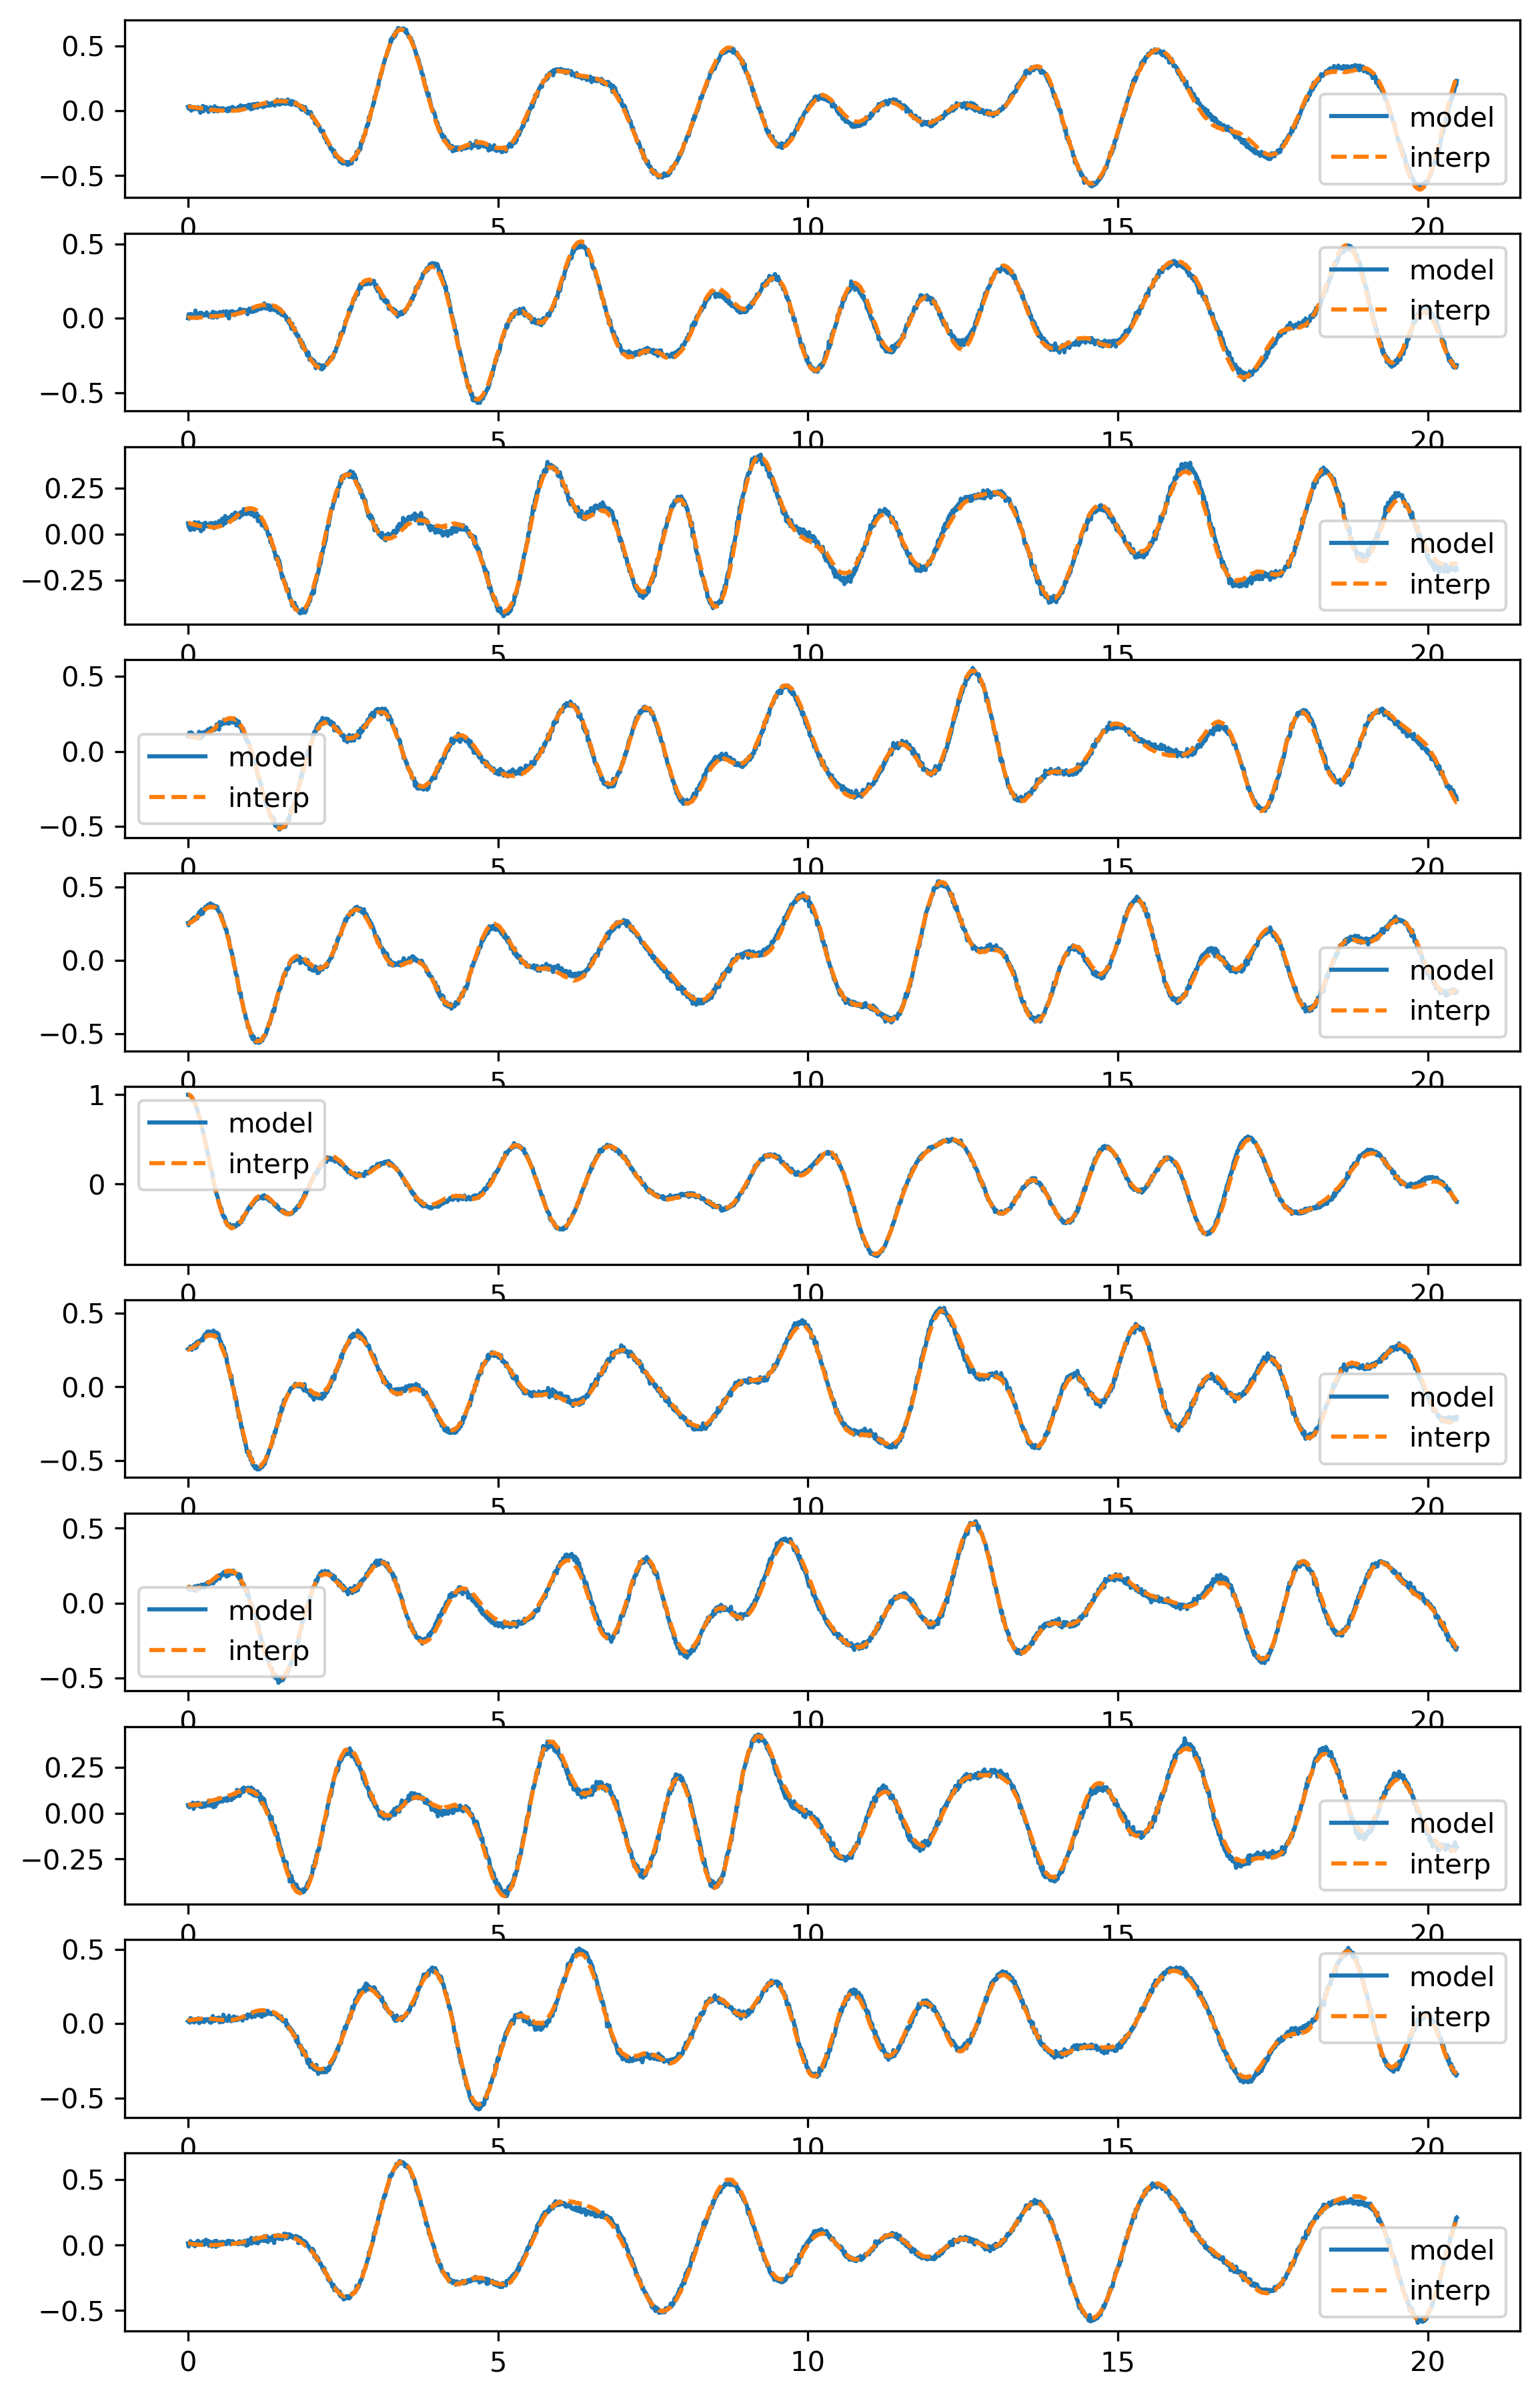

In [96]:
fig, axs = plt.subplots(nrows=D, figsize=(9,15), dpi=300)


for i,item in enumerate(D_list):
    # axs[i].plot(ts, np.imag(func_vals_noise[:,item]), '-', label = 'model')
    # axs[i].plot(ts, np.imag(func_interp_noise[:,item]), '--', label = 'interp')
    axs[i].plot(ts, np.real(func_vals_noise[:,item]), '-', label = 'model')
    axs[i].plot(ts, np.real(func_interp_noise[:,item]), '--', label = 'interp')
    axs[i].legend()

plt.show()  

1. Create error vs eval plots (error between interpolation and noisy function)

<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\c'
/var/folders/6j/zg3nz4053f97fyqx4w2b6pxc0000gn/T/ipykernel_75783/2662806102.py:37: SyntaxWarning: invalid escape sequence '\c'
  plt.plot([], [], ' ', label="Numbers: $\chi$ values")  # Dummy plot for chi explanation


err_max:  0.6820968269502619
err_2:  0.8173191563153255

repeated evaluations:  148
unique evaluations 72
unique + repeated:  220
total evaluations:  220

err_max:  0.6548918453081715
err_2:  0.7203152533947188

repeated evaluations:  574
unique evaluations 138
unique + repeated:  712
total evaluations:  712

err_max:  0.49011557682932344
err_2:  0.5185508447329881

repeated evaluations:  1340
unique evaluations 224
unique + repeated:  1564
total evaluations:  1564

err_max:  0.28673544431371084
err_2:  0.2899708797649691

repeated evaluations:  2506
unique evaluations 310
unique + repeated:  2816
total evaluations:  2816

err_max:  0.07785476003012931
err_2:  0.0797624297289923

repeated evaluations:  4108
unique evaluations 408
unique + repeated:  4516
total evaluations:  4516

err_max:  0.06519618659122552
err_2:  0.0667484029552233

repeated evaluations:  6210
unique evaluations 518
unique + repeated:  6728
total evaluations:  6728

err_max:  0.06383942847686115
err_2:  0.064768280

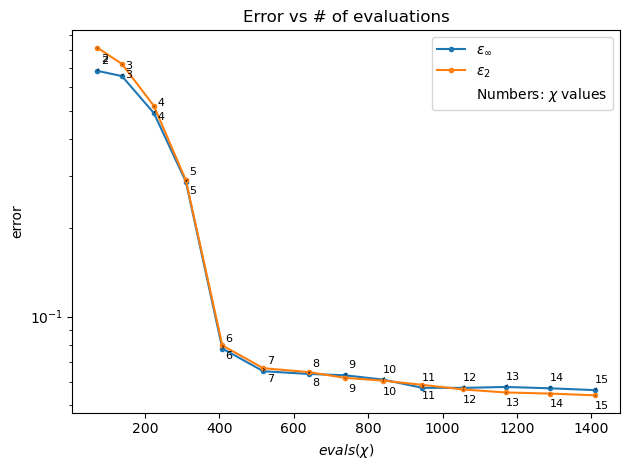

In [97]:
err_max_TCI_noise = []
err_2_TCI_noise = []
evals_TCI_noise = []
func_interp_list_TCI_noise = []
iter_list = [i for i in range(1,15)]


for iter in iter_list:
    func = TCI.function(f_t_noise)
    _, _, eval, err2, errmax, func_interp = TCI.accumulative_tensor_cross_interpolation(func,         # function to be interpolated
                                   func_vals_noise,    
                                   D,
                                   L=n,          # number of MPS tensors
                                   iters=iter)       # number of back-and-forth sweeps
    err_max_TCI_noise.append(errmax)
    err_2_TCI_noise.append(err2)
    evals_TCI_noise.append(eval)
    func_interp_list_TCI_noise.append(func_interp)

plt.plot(np.array(evals_TCI_noise), np.array(err_max_TCI_noise), ".-", label = r"$\epsilon_\infty$")
plt.plot(np.array(evals_TCI_noise), np.array(err_2_TCI_noise), ".-", label = r"$\epsilon_2$")

# Annotate the points with their chi values
for i, iter in enumerate(iter_list):
    # Annotate error_max (first curve)
    plt.annotate(f"{iter+1}", (evals_TCI_noise[i], err_max_TCI_noise[i]),
                 textcoords="offset points", xytext=(5, 5), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')

    # Annotate error_2 (second curve)
    plt.annotate(f"{iter+1}", (evals_TCI_noise[i], err_2_TCI_noise[i]),
                 textcoords="offset points", xytext=(5, -10), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')
    
plt.plot([], [], ' ', label="Numbers: $\chi$ values")  # Dummy plot for chi explanation

plt.yscale("log")
plt.xlabel(r"$evals(\chi)$")
plt.ylabel(r"error")
plt.legend()
plt.title("Error vs # of evaluations")
plt.tight_layout()
plt.savefig("figures_Lsite_noise/noise_error_vs_evals_TCI_Dsites.pdf")
plt.show()

2. Create error vs eval plots (error between interpolation and theoretical function)

<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\c'
/var/folders/6j/zg3nz4053f97fyqx4w2b6pxc0000gn/T/ipykernel_75783/205348064.py:37: SyntaxWarning: invalid escape sequence '\c'
  plt.plot([], [], ' ', label="Numbers: $\chi$ values")  # Dummy plot for chi explanation


err_max:  0.6694500321725282
err_2:  0.8167685483865473

repeated evaluations:  148
unique evaluations 72
unique + repeated:  220
total evaluations:  220

err_max:  0.6508484805582133
err_2:  0.7196111895848321

repeated evaluations:  574
unique evaluations 138
unique + repeated:  712
total evaluations:  712

err_max:  0.46628520441022325
err_2:  0.5171946962471352

repeated evaluations:  1340
unique evaluations 224
unique + repeated:  1564
total evaluations:  1564

err_max:  0.27231491001278463
err_2:  0.28672858025783515

repeated evaluations:  2506
unique evaluations 310
unique + repeated:  2816
total evaluations:  2816

err_max:  0.06207167948246311
err_2:  0.06532994681147647

repeated evaluations:  4108
unique evaluations 408
unique + repeated:  4516
total evaluations:  4516

err_max:  0.03807686479027678
err_2:  0.048815217835958206

repeated evaluations:  6210
unique evaluations 518
unique + repeated:  6728
total evaluations:  6728

err_max:  0.0389298719486041
err_2:  0.046114

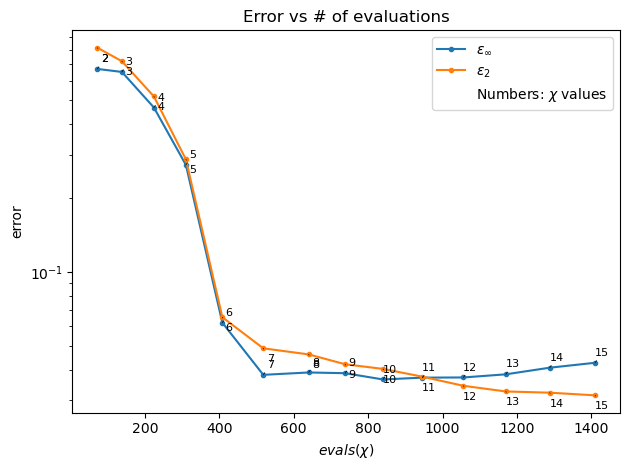

In [98]:
err_max_TCI = []
err_2_TCI = []
evals_TCI = []
func_interp_list_TCI = []
iter_list = [i for i in range(1,15)]


for iter in iter_list:
    func = TCI.function(f_t_noise)
    _, _, eval, err2, errmax, func_interp = TCI.accumulative_tensor_cross_interpolation(func,         # function to be interpolated
                                   func_vals_theo,    
                                   D,
                                   L=n,          # number of MPS tensors
                                   iters=iter)       # number of back-and-forth sweeps
    err_max_TCI.append(errmax)
    err_2_TCI.append(err2)
    evals_TCI.append(eval)
    func_interp_list_TCI.append(func_interp)

plt.plot(np.array(evals_TCI), np.array(err_max_TCI), ".-", label = r"$\epsilon_\infty$")
plt.plot(np.array(evals_TCI), np.array(err_2_TCI), ".-", label = r"$\epsilon_2$")

# Annotate the points with their chi values
for i, iter in enumerate(iter_list):
    # Annotate error_max (first curve)
    plt.annotate(f"{iter+1}", (evals_TCI[i], err_max_TCI[i]),
                 textcoords="offset points", xytext=(5, 5), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')

    # Annotate error_2 (second curve)
    plt.annotate(f"{iter+1}", (evals_TCI[i], err_2_TCI[i]),
                 textcoords="offset points", xytext=(5, -10), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')
    
plt.plot([], [], ' ', label="Numbers: $\chi$ values")  # Dummy plot for chi explanation

plt.yscale("log")
plt.xlabel(r"$evals(\chi)$")
plt.ylabel(r"error")
plt.legend()
plt.title("Error vs # of evaluations")
plt.tight_layout()
plt.savefig("figures_Lsite_noise/theo_error_vs_evals_Chebyshev_Dsites.pdf")
plt.show()

### Chebyshev

In [99]:
import numpy as np
import matplotlib.pyplot as plt

import Chebyshev as Cbs
importlib.reload(Cbs)

<module 'Chebyshev' from '/Users/giovanniconcheri/Desktop/ResearchJob/Student-Research-Job/Chebyshev/Chebyshev.py'>

In [100]:
# compute correlator

# compute correlator
dt = 1e-2
n = 11
N = 2**n
D = 11
N_shots = 8192
rng = None

def corr_Chebyshev_noisy(D_list, t_matrix, dt = dt, n = n, Sx = True, N_shots=N_shots, rng=rng):
    corr_theo = ED.correlator_Chebyshev(D_list, t_matrix, H=Hlist[0], dt = dt,  n = n, Sx = Sx)
    # ensure values lie in [-1,1] and avoid tiny negative values inside sqrt
    real_clipped = np.clip(corr_theo.real, -1.0, 1.0)
    imag_clipped = np.clip(corr_theo.imag, -1.0, 1.0)

    std_real = np.sqrt(np.clip(1.0 - real_clipped**2, 0.0, None)) / np.sqrt(N_shots)
    std_imag = np.sqrt(np.clip(1.0 - imag_clipped**2, 0.0, None)) / np.sqrt(N_shots)

    if rng is None:
        rng = np.random.default_rng()
    corr_noise_real = rng.normal(loc=0.0, scale=std_real)
    corr_noise_imag = rng.normal(loc=0.0, scale=std_imag)

    corr_noise = corr_theo + corr_noise_real + 1j * corr_noise_imag
    return corr_noise

# exact function values
#xs = np.linspace(0, N*dt, 2**n, endpoint=False)
ts = np.arange(N)*dt

# get MPS from Chebyshev interpolation
chi = 50
As, evals, err_max, err_2, func_interp = Cbs.Chebyshev_interpolation_Dsite(corr_Chebyshev_noisy, # function to be interpolated
                                 func_vals_noise,
                                 L=n,              # number of MPS tensors
                                 D = D,
                                 chi=chi)           # (half of the) bond dimension



In [101]:
print(err_2)
print(err_max)

0.06553613575691902
0.07492590495323587


In [102]:
#here we could define a dictionary to make things more compact
err_max_Chebyshev_noise = []
err_2_Chebyshev_noise = []
evals_Chebyshev_noise = []
func_interp_list_Chebyshev_noise = []

# this chi_list works well for D = 11, n = 10
# chi_list = [i for i in range(2,10)]
# chi_list.extend([i for i in range(10,40,5)])
# chi_list.append(70)

#this chi_list works well for D=11, n=12
chi_list = [10,20, 28,35,100,200,350,525,700]

for chi in chi_list:
# get MPS from Chebyshev interpolation
    _, eval, errmax, err2, func_interp = Cbs.Chebyshev_interpolation_Dsite(corr_Chebyshev_noisy, # function to be interpolated
                                 func_vals_noise,
                                 L=n,              # number of MPS tensors
                                 D = D,
                                 chi=chi)           # (half of the) bond dimension

    err_max_Chebyshev_noise.append(errmax)
    err_2_Chebyshev_noise.append(err2)
    evals_Chebyshev_noise.append(eval)
    func_interp_list_Chebyshev_noise.append(func_interp)




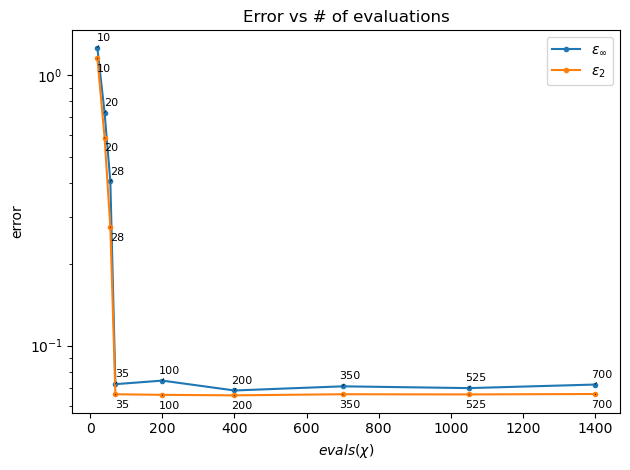

In [103]:
plt.plot(np.array(evals_Chebyshev_noise), np.array(err_max_Chebyshev_noise), ".-", label = r"$\epsilon_\infty$")
plt.plot(np.array(evals_Chebyshev_noise), np.array(err_2_Chebyshev_noise), ".-", label = r"$\epsilon_2$")

# Annotate the points with their chi values
for i, chi in enumerate(chi_list):
    # Annotate error_max (first curve)
    plt.annotate(f"{chi}", (evals_Chebyshev_noise[i], err_max_Chebyshev_noise[i]),
                 textcoords="offset points", xytext=(5, 5), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')

    # Annotate error_2 (second curve)
    plt.annotate(f"{chi}", (evals_Chebyshev_noise[i], err_2_Chebyshev_noise[i]),
                 textcoords="offset points", xytext=(5, -10), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')
    

plt.yscale("log")
plt.xlabel(r"$evals(\chi)$")
plt.ylabel(r"error")
plt.legend()
plt.title("Error vs # of evaluations")
plt.tight_layout()
plt.savefig("figures_Lsite_noise/noise_error_vs_evals_Chebyshev_D11_n11.pdf")
plt.show()

In [104]:
#here we could define a dictionary to make things more compact
err_max_Chebyshev_theo = []
err_2_Chebyshev_theo = []
evals_Chebyshev_theo = []
func_interp_list_Chebyshev_theo = []

# this chi_list works well for D = 11, n = 10
# chi_list = [i for i in range(2,10)]
# chi_list.extend([i for i in range(10,40,5)])
# chi_list.append(70)

#this chi_list works well for D=11, n=12
chi_list = [10,20, 28,35,100,200,350,525,700]

for chi in chi_list:
# get MPS from Chebyshev interpolation
    _, eval, errmax, err2, func_interp = Cbs.Chebyshev_interpolation_Dsite(corr_Chebyshev_noisy, # function to be interpolated
                                 func_vals_theo,
                                 L=n,              # number of MPS tensors
                                 D = D,
                                 chi=chi)           # (half of the) bond dimension

    err_max_Chebyshev_theo.append(errmax)
    err_2_Chebyshev_theo.append(err2)
    evals_Chebyshev_theo.append(eval)
    func_interp_list_Chebyshev_theo.append(func_interp)

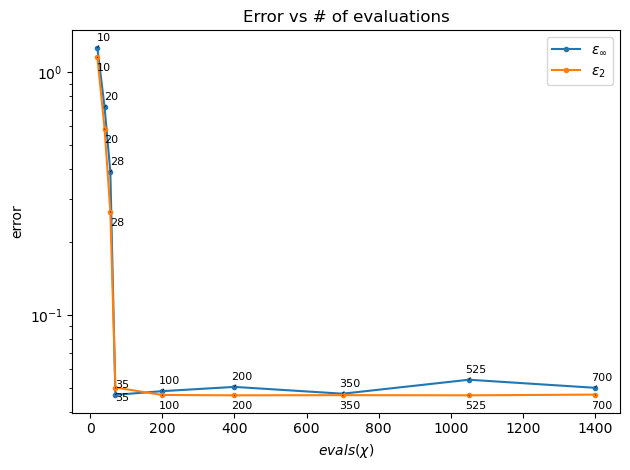

In [105]:
plt.plot(np.array(evals_Chebyshev_theo), np.array(err_max_Chebyshev_theo), ".-", label = r"$\epsilon_\infty$")
plt.plot(np.array(evals_Chebyshev_theo), np.array(err_2_Chebyshev_theo), ".-", label = r"$\epsilon_2$")

# Annotate the points with their chi values
for i, chi in enumerate(chi_list):
    # Annotate error_max (first curve)
    plt.annotate(f"{chi}", (evals_Chebyshev_theo[i], err_max_Chebyshev_theo[i]),
                 textcoords="offset points", xytext=(5, 5), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')

    # Annotate error_2 (second curve)
    plt.annotate(f"{chi}", (evals_Chebyshev_theo[i], err_2_Chebyshev_theo[i]),
                 textcoords="offset points", xytext=(5, -10), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')
    

plt.yscale("log")
plt.xlabel(r"$evals(\chi)$")
plt.ylabel(r"error")
plt.legend()
plt.title("Error vs # of evaluations")
plt.tight_layout()
plt.savefig("figures_Lsite_noise/theo_error_vs_evals_Chebyshev_D11_n11.pdf")
plt.show()

## FINAL PLOT
of all the errors vs evals in noisy cases for both TCI and Chebyshev

<>:22: SyntaxWarning: invalid escape sequence '\c'
<>:22: SyntaxWarning: invalid escape sequence '\c'
/var/folders/6j/zg3nz4053f97fyqx4w2b6pxc0000gn/T/ipykernel_75783/2519830216.py:22: SyntaxWarning: invalid escape sequence '\c'
  plt.plot([], [], ' ', label="Numbers: $\chi$ values")  # Dummy plot for chi explanation


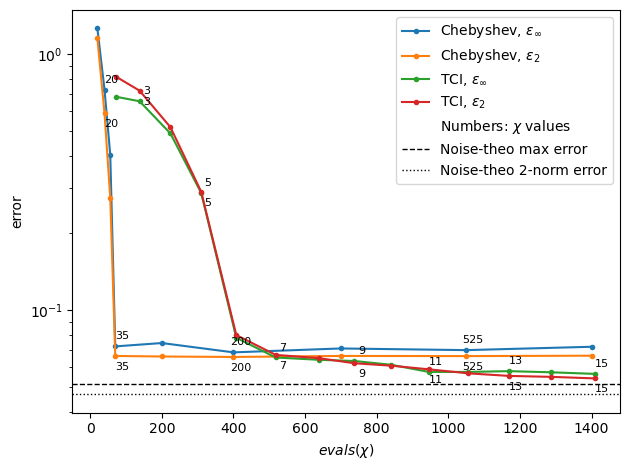

In [106]:
plt.plot(np.array(evals_Chebyshev_noise), np.array(err_max_Chebyshev_noise), ".-", label = r"Chebyshev, $\epsilon_\infty$")
plt.plot(np.array(evals_Chebyshev_noise), np.array(err_2_Chebyshev_noise), ".-", label = r"Chebyshev, $\epsilon_2$")
plt.plot(np.array(evals_TCI_noise), np.array(err_max_TCI_noise), ".-", label = r"TCI, $\epsilon_\infty$")
plt.plot(np.array(evals_TCI_noise), np.array(err_2_TCI_noise), ".-", label = r"TCI, $\epsilon_2$")

# Annotate the points with their chi values
for i, iter in enumerate(iter_list):
    if i % 2 == 0:
        continue  # Skip every second annotation to reduce clutter
    # Annotate error_max (first curve)
    plt.annotate(f"{iter+1}", (evals_TCI_noise[i], err_max_TCI_noise[i]),
                 textcoords="offset points", xytext=(5, 5), fontsize=8,
                #  arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')

    # Annotate error_2 (second curve)
    plt.annotate(f"{iter+1}", (evals_TCI_noise[i], err_2_TCI_noise[i]),
                 textcoords="offset points", xytext=(5, -10), fontsize=8,
                #  arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')

plt.plot([], [], ' ', label="Numbers: $\chi$ values")  # Dummy plot for chi explanation

# Annotate the points with their chi values
for i, chi in enumerate(chi_list):
    if i % 2 == 0:
        continue  # Skip every second annotation to reduce clutter
    # Annotate error_max (first curve)
    plt.annotate(f"{chi}", (evals_Chebyshev_noise[i], err_max_Chebyshev_noise[i]),
                 textcoords="offset points", xytext=(5, 5), fontsize=8,
                #  arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')

    # Annotate error_2 (second curve)
    plt.annotate(f"{chi}", (evals_Chebyshev_noise[i], err_2_Chebyshev_noise[i]),
                 textcoords="offset points", xytext=(5, -10), fontsize=8,
                #  arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')

plt.axhline(y=err_max_noisevstheo, color='k', linestyle='--', linewidth=1, label='Noise-theo max error')
plt.axhline(y=err_2_noisevstheo, color='k', linestyle=':', linewidth=1, label='Noise-theo 2-norm error')


plt.yscale("log")
plt.xlabel(r"$evals(\chi)$")
plt.ylabel(r"error")
plt.legend()
# plt.title("Error between noisy correlator and Chebyshev interpolation vs # of evaluations")
plt.tight_layout()
plt.savefig("figures_Lsite_noise/TOTAL_noise_error_vs_evals_D11_n11_no_title.pdf")
plt.show()